In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from os.path import dirname, join as pjoin
import scipy.io as sio
import h5py
import hdf5storage
import random
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from PIL import Image
from matplotlib.image import imread
import os
from tensorflow.keras import applications
from sklearn.datasets import load_svmlight_file
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing import sequence
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional, Conv1D, Flatten, GRU, AveragePooling1D

Using TensorFlow backend.


In [2]:
DATASET_URL = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

In [3]:
data_root_orig = tf.keras.utils.get_file(origin=DATASET_URL, fname='aclImdb', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

nltk.download('punkt')

/home/maxim/.keras/datasets/aclImdb


[nltk_data] Downloading package punkt to /home/maxim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
PATH_TO_TRAIN = str(data_root) + '/train'
PATH_TO_TEST =str(data_root) + '/test'

In [5]:
import re

NUM_TOKEN = '<num>'
UNKNOWN_TOKEN = '<unk>'
EMPTY_TOKEN = '<emp>'

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', raw_html)
    return cleantext

def review_to_indices(text, vocab):
    indecies = []
    for text_word in text:
        word = text_word.lower()
        index = -1
        # try find word in vocab
        try:
            index = vocab.index(word)
        except:
            # if we can't find it - try to parse it to int
            try:
                i = int(word)
                index = vocab.index(NUM_TOKEN)
            except:
                # else it unknown
                index = vocab.index(UNKNOWN_TOKEN)
        indecies.append(index)
    return indecies
                
   

In [6]:
# load data

# load vocab

vocab = []

with open(str(data_root) + '/imdb.vocab', 'r') as file:
    vocab = file.read().splitlines()
    vocab.append(EMPTY_TOKEN)
    vocab.append(NUM_TOKEN)
    vocab.append(UNKNOWN_TOKEN)
    print('Added <EMP>, <NUM> and <UNK> tokens')
    print('Vocab len =', len(vocab))
    
tokenizer = RegexpTokenizer(r'\w+')

total_review_len = 0
total_review_count = 0

reviews = []

for review_name in os.listdir(PATH_TO_TRAIN + '/pos'):
    mark = int(review_name.split('_')[1].split('.')[0])
    path = PATH_TO_TRAIN + '/pos/' + review_name
    with open(path, 'r') as file:
        data = file.read()
        clean_review = cleanhtml(data)
        indecies = review_to_indices(tokenizer.tokenize(clean_review), vocab)
        total_review_len += len(indecies)
        total_review_count += 1
        reviews.append((indecies, mark))

        
for review_name in os.listdir(PATH_TO_TRAIN + '/neg'):
    mark = int(review_name.split('_')[1].split('.')[0])
    path = PATH_TO_TRAIN + '/neg/' + review_name
    with open(path, 'r') as file:
        data = file.read()
        clean_review = cleanhtml(data)
        indecies = review_to_indices(tokenizer.tokenize(clean_review), vocab)
        total_review_len += len(indecies)
        total_review_count += 1
        reviews.append((indecies, mark))
        

print(len(reviews))
print(reviews[10])

print(len(reviews))
print(reviews[13000])

Added <EMP>, <NUM> and <UNK> tokens
Vocab len = 89530
25000
([9, 5, 2, 49, 214, 70, 621, 1527, 15, 82, 6, 5, 2, 931, 1127, 0, 356, 1182, 22, 321, 1, 0, 109, 5, 255, 6, 39, 19, 178, 48, 252, 6515, 9118, 6, 528, 79, 7, 5495, 59, 1469, 6, 388, 2, 526, 3, 2, 145, 1425, 418, 1, 19, 2, 1527, 15, 16, 3, 254, 6, 5, 2, 1527, 1, 2, 62, 48, 26, 14, 314, 1281, 461, 809, 1, 1357, 1, 30, 0, 93, 0, 381, 5, 902, 103, 44, 13, 9, 26], 8)
25000
([2, 175, 621, 4300, 89529, 989, 363, 739, 374, 3, 1761, 1, 562, 3, 2045, 47, 1468, 151, 1605, 2693, 743, 3, 2914, 1825, 1, 75, 1342, 353, 18, 2, 2482, 2559, 9, 43, 156, 4, 81, 14, 17075, 29, 216, 19, 7, 54, 1123, 5360, 301, 9, 1123, 278, 763, 5, 477, 38215, 37593, 1, 43, 5847, 41659, 981, 419, 6376, 4817, 1, 31241, 82, 63, 1334, 538, 23, 26, 21, 528, 0, 60, 4835, 91, 20, 24, 6376, 4817, 1, 31241, 981, 245, 78, 82, 33, 32151, 1, 0, 1334, 3309, 1, 20, 24, 31241, 981, 419, 286, 82, 21, 528, 40, 0, 1082, 1, 87, 4495, 19282, 535, 1190, 10, 528, 6, 55, 49, 11494, 7, 0,

In [7]:
average_review_len = int(total_review_len / total_review_count)

print(total_review_len)
print(total_review_count)
print(average_review_len)

5954856
25000
238


In [8]:
x = []
y = []

np_vocab = np.asarray(vocab)

random.shuffle(reviews)

i = 0

for review in reviews:
    review_rep = np.asarray(review[0][:average_review_len])
    x.append(review_rep)
#     one_hot_rep = np.zeros((vocab.size, review_rep.max() + 1))
#     one_hot_rep[np.arange(review_rep.size), review_rep] = 1
    y.append(review[1])
    
y = np.asarray(y)
x = sequence.pad_sequences(x, maxlen=average_review_len)

# print(review_rep)
# one_hot_rep = np.zeros((np_vocab.size, 1))
# one_hot_rep[review_rep[0], 0] = 1.
# one_hot_rep[0, 0]
# len(one_hot_rep)
# one_hot_rep[np.arange(review_rep.size), review_rep] = 1
# print(review_rep[0])
# print(one_hot_rep[0][review_rep[0]])

In [9]:
BATCH_SIZE = 64
EPOCHS = 10

input_lstm = layers.LSTM(100, input_shape=(1, average_review_len))
output_0 = layers.Dense(11, activation='softmax', name='output')

model_without_emb = keras.Sequential([
        input_lstm,
        output_0,
    ])
model_without_emb.summary()
model_without_emb.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               135600    
_________________________________________________________________
output (Dense)               (None, 11)                1111      
Total params: 136,711
Trainable params: 136,711
Non-trainable params: 0
_________________________________________________________________


In [10]:
EMB_SIZE = 32

emb_1 = Embedding(len(vocab), EMB_SIZE, input_length=average_review_len)
lstm_1 = Bidirectional(LSTM(100))
out = Dense(11, activation='softmax')

simple_lstm_model = Sequential([
    emb_1,
    lstm_1,
    out
])

simple_lstm_model.summary()
simple_lstm_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 238, 32)           2864960   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               106400    
_________________________________________________________________
dense_1 (Dense)              (None, 11)                2211      
Total params: 2,973,571
Trainable params: 2,973,571
Non-trainable params: 0
_________________________________________________________________


In [11]:
y_oh = np.zeros((y.size, y.max()+1))
y_oh[np.arange(y.size),y] = 1

x_train = x[:23000]
x_validation = x[23001:25000]

y_oh_train = y_oh[:23000]
y_oh_validation = y_oh[23001:25000]

x_train_r = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_validation_r = np.reshape(x_validation, (x_validation.shape[0], 1, x_validation.shape[1]))

In [12]:
model_without_emb_history = model_without_emb.fit(
    x_train_r,
    y_oh_train,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(x_validation_r, y_oh_validation)
)

Train on 23000 samples, validate on 1999 samples
Epoch 1/10
23000/23000 [==============================] - 3s 118us/sample - loss: 2.2686 - accuracy: 0.1516 - val_loss: 2.1466 - val_accuracy: 0.1731
Epoch 2/10
23000/23000 [==============================] - 1s 50us/sample - loss: 2.0901 - accuracy: 0.1881 - val_loss: 2.0818 - val_accuracy: 0.1801
Epoch 3/10
23000/23000 [==============================] - 1s 54us/sample - loss: 2.0478 - accuracy: 0.1961 - val_loss: 2.0553 - val_accuracy: 0.1846
Epoch 4/10
23000/23000 [==============================] - 1s 54us/sample - loss: 2.0298 - accuracy: 0.2026 - val_loss: 2.0484 - val_accuracy: 0.1911
Epoch 5/10
23000/23000 [==============================] - 1s 54us/sample - loss: 2.0214 - accuracy: 0.2043 - val_loss: 2.0487 - val_accuracy: 0.1896
Epoch 6/10
23000/23000 [==============================] - 1s 60us/sample - loss: 2.0167 - accuracy: 0.2077 - val_loss: 2.0407 - val_accuracy: 0.1901
Epoch 7/10
23000/23000 [==============================] 

In [13]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

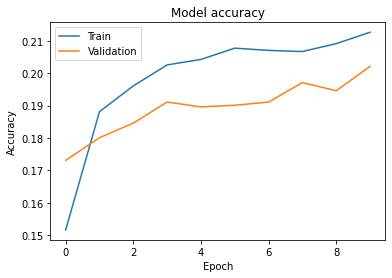

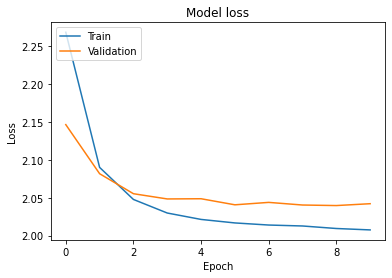

In [14]:
plot_history(model_without_emb_history)

In [15]:

simple_lstm_model_history = simple_lstm_model.fit(
    x_train,
    y_oh_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_validation, y_oh_validation)
)

/home/maxim/.local/share/virtualenvs/deep-learning-wM6lnET7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 23000 samples, validate on 1999 samples
Epoch 1/10
23000/23000 [==============================] - 130s 6ms/step - loss: 1.9261 - accuracy: 0.2707 - val_loss: 1.7437 - val_accuracy: 0.3332
Epoch 2/10
23000/23000 [==============================] - 128s 6ms/step - loss: 1.5666 - accuracy: 0.3839 - val_loss: 1.6330 - val_accuracy: 0.3497
Epoch 3/10
23000/23000 [==============================] - 127s 6ms/step - loss: 1.3812 - accuracy: 0.4429 - val_loss: 1.6093 - val_accuracy: 0.3767
Epoch 4/10
23000/23000 [==============================] - 125s 5ms/step - loss: 1.2275 - accuracy: 0.5090 - val_loss: 1.7327 - val_accuracy: 0.3732
Epoch 5/10
23000/23000 [==============================] - 125s 5ms/step - loss: 1.0674 - accuracy: 0.5724 - val_loss: 1.8778 - val_accuracy: 0.3687
Epoch 6/10
23000/23000 [==============================] - 125s 5ms/step - loss: 0.9197 - accuracy: 0.6387 - val_loss: 1.9492 - val_accuracy: 0.3637
Epoch 7/10
23000/23000 [==============================] - 129s 

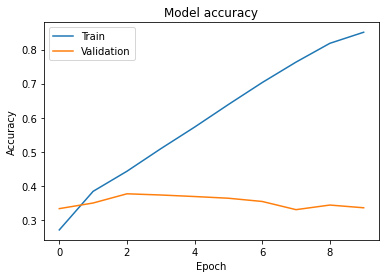

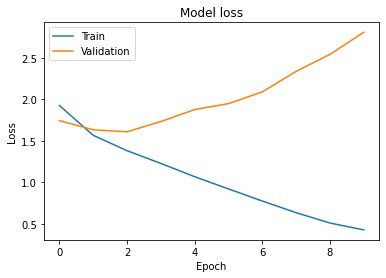

In [16]:
plot_history(simple_lstm_model_history)

In [17]:
def predict_review(model, average_review_len, review):
    m_reviews = []
    t_review = np.asarray(review_to_indices(tokenizer.tokenize(review), vocab))
    m_reviews.append(t_review)
    t_review = sequence.pad_sequences(m_reviews, maxlen=average_review_len)
    prediction = model.predict(t_review)
    print(review)
    print('RNN thinks this movie should get... {} out of 10'.format(prediction.argmax()))

    
bad_review = "Really crap. Steven Spielberg is a very bad director and his movies are piece of shit!"
predict_review(simple_lstm_model, average_review_len, bad_review)

good_review = "Really nice and enjoyable movie. I will recomend it to my friends. I think they will love it too!"
predict_review(simple_lstm_model, average_review_len, good_review)

neutral_review = "I don't know what to think after this movie, it is so-so. Some moments was not so interesting. But it still pretty nice movie"
predict_review(simple_lstm_model, average_review_len, neutral_review)



Really crap. Steven Spielberg is a very bad director and his movies are piece of shit!
RNN thinks this movie should get... 2 out of 10
Really nice and enjoyable movie. I will recomend it to my friends. I think they will love it too!
RNN thinks this movie should get... 10 out of 10
I don't know what to think after this movie, it is so-so. Some moments was not so interesting. But it still pretty nice movie
RNN thinks this movie should get... 7 out of 10


In [18]:
# RNN with 2 LSTMs
emb_1_1 = Embedding(len(vocab), EMB_SIZE, input_length=average_review_len)
lstm_1_1 = Bidirectional(LSTM(100, return_sequences=True))
lstm_1_2 = Bidirectional(LSTM(100))
out_2lstm = Dense(11, activation='softmax')

simple_lstm_model_with_2_lstm = Sequential([
    emb_1_1,
    lstm_1_1,
    lstm_1_2,
    out_2lstm
])

simple_lstm_model_with_2_lstm.summary()
simple_lstm_model_with_2_lstm.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 238, 32)           2864960   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 238, 200)          106400    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_2 (Dense)              (None, 11)                2211      
Total params: 3,214,371
Trainable params: 3,214,371
Non-trainable params: 0
_________________________________________________________________


In [19]:
simple_lstm_model_with_2_lstm_history = simple_lstm_model_with_2_lstm.fit(
    x_train,
    y_oh_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_validation, y_oh_validation)
)

/home/maxim/.local/share/virtualenvs/deep-learning-wM6lnET7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 23000 samples, validate on 1999 samples
Epoch 1/10
23000/23000 [==============================] - 303s 13ms/step - loss: 1.9200 - accuracy: 0.2665 - val_loss: 1.7175 - val_accuracy: 0.3302
Epoch 2/10
23000/23000 [==============================] - 301s 13ms/step - loss: 1.5234 - accuracy: 0.4109 - val_loss: 1.6073 - val_accuracy: 0.3712
Epoch 3/10
23000/23000 [==============================] - 301s 13ms/step - loss: 1.3734 - accuracy: 0.4689 - val_loss: 2.0379 - val_accuracy: 0.2226
Epoch 4/10
23000/23000 [==============================] - 300s 13ms/step - loss: 1.4521 - accuracy: 0.4468 - val_loss: 1.8178 - val_accuracy: 0.3622
Epoch 5/10
23000/23000 [==============================] - 300s 13ms/step - loss: 1.1558 - accuracy: 0.5425 - val_loss: 1.7429 - val_accuracy: 0.3737
Epoch 6/10
23000/23000 [==============================] - 300s 13ms/step - loss: 1.0078 - accuracy: 0.6057 - val_loss: 1.8647 - val_accuracy: 0.3702
Epoch 7/10
23000/23000 [==============================] -

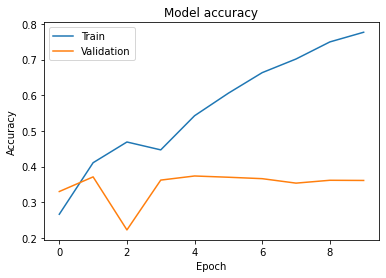

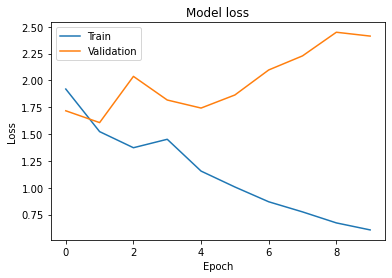

In [20]:
plot_history(simple_lstm_model_with_2_lstm_history)

In [21]:
# RNN with LSTM and Pooling layers
emb_2_1 = Embedding(len(vocab), EMB_SIZE, input_length=average_review_len)
pooling_1 = AveragePooling1D()
lstm_2_1 = Bidirectional(LSTM(100))
out_pooling = Dense(11, activation='softmax')

lstm_with_pooling = Sequential([
    emb_2_1,
    pooling_1,
    lstm_2_1,
    out_pooling
])

lstm_with_pooling.summary()
lstm_with_pooling.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 238, 32)           2864960   
_________________________________________________________________
average_pooling1d_1 (Average (None, 119, 32)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               106400    
_________________________________________________________________
dense_3 (Dense)              (None, 11)                2211      
Total params: 2,973,571
Trainable params: 2,973,571
Non-trainable params: 0
_________________________________________________________________


In [22]:
lstm_with_pooling_history = lstm_with_pooling.fit(
    x_train,
    y_oh_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_validation, y_oh_validation)
)

/home/maxim/.local/share/virtualenvs/deep-learning-wM6lnET7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 23000 samples, validate on 1999 samples
Epoch 1/10
23000/23000 [==============================] - 76s 3ms/step - loss: 1.9812 - accuracy: 0.2450 - val_loss: 1.7262 - val_accuracy: 0.3397
Epoch 2/10
23000/23000 [==============================] - 75s 3ms/step - loss: 1.5612 - accuracy: 0.4006 - val_loss: 1.6712 - val_accuracy: 0.3712
Epoch 3/10
23000/23000 [==============================] - 76s 3ms/step - loss: 1.4004 - accuracy: 0.4468 - val_loss: 1.5861 - val_accuracy: 0.3742
Epoch 4/10
23000/23000 [==============================] - 75s 3ms/step - loss: 1.2504 - accuracy: 0.5011 - val_loss: 1.6189 - val_accuracy: 0.3837
Epoch 5/10
23000/23000 [==============================] - 72s 3ms/step - loss: 1.0734 - accuracy: 0.5685 - val_loss: 1.7267 - val_accuracy: 0.3792
Epoch 6/10
23000/23000 [==============================] - 67s 3ms/step - loss: 0.9125 - accuracy: 0.6404 - val_loss: 1.8780 - val_accuracy: 0.3712
Epoch 7/10
23000/23000 [==============================] - 67s 3ms/ste

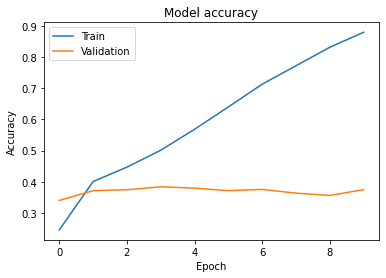

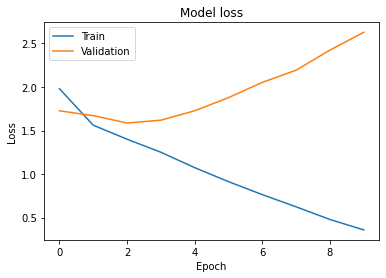

In [23]:
plot_history(lstm_with_pooling_history)

In [24]:
# RNN with LSTM and Conv layers
emb_3_1 = Embedding(len(vocab), EMB_SIZE, input_length=average_review_len)
conv_2_1 = Conv1D(16, kernel_size=3, padding='same')
conv_2_2 = Conv1D(32, kernel_size=3, padding='same')
pooling_2 = AveragePooling1D()
lstm_3_1 = Bidirectional(LSTM(100))
out_conv = Dense(11, activation='softmax')

lstm_with_conv = Sequential([
    emb_3_1,
    conv_2_1,
    conv_2_2,
    pooling_2,
    lstm_3_1,
    out_conv
])

lstm_with_conv.summary()
lstm_with_conv.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 238, 32)           2864960   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 238, 16)           1552      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 238, 32)           1568      
_________________________________________________________________
average_pooling1d_2 (Average (None, 119, 32)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               106400    
_________________________________________________________________
dense_4 (Dense)              (None, 11)                2211      
Total params: 2,976,691
Trainable params: 2,976,691
Non-trainable params: 0
____________________________________________

In [25]:
lstm_with_conv_history = lstm_with_conv.fit(
    x_train,
    y_oh_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_validation, y_oh_validation)
)

/home/maxim/.local/share/virtualenvs/deep-learning-wM6lnET7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 23000 samples, validate on 1999 samples
Epoch 1/10
23000/23000 [==============================] - 72s 3ms/step - loss: 1.9262 - accuracy: 0.2667 - val_loss: 1.7779 - val_accuracy: 0.3217
Epoch 2/10
23000/23000 [==============================] - 72s 3ms/step - loss: 1.5448 - accuracy: 0.4013 - val_loss: 1.6685 - val_accuracy: 0.3622
Epoch 3/10
23000/23000 [==============================] - 71s 3ms/step - loss: 1.2650 - accuracy: 0.4952 - val_loss: 1.6185 - val_accuracy: 0.3822
Epoch 4/10
23000/23000 [==============================] - 71s 3ms/step - loss: 1.0343 - accuracy: 0.5829 - val_loss: 1.7751 - val_accuracy: 0.3747
Epoch 5/10
23000/23000 [==============================] - 72s 3ms/step - loss: 0.8511 - accuracy: 0.6690 - val_loss: 1.9571 - val_accuracy: 0.3682
Epoch 6/10
23000/23000 [==============================] - 72s 3ms/step - loss: 0.6923 - accuracy: 0.7402 - val_loss: 2.2575 - val_accuracy: 0.3547
Epoch 7/10
23000/23000 [==============================] - 72s 3ms/ste

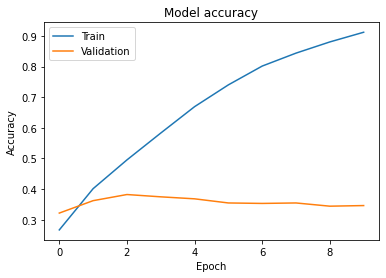

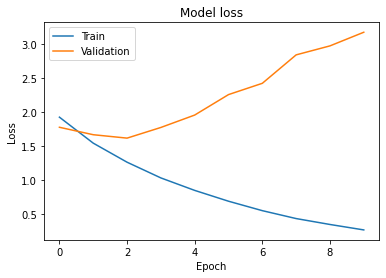

In [26]:
plot_history(lstm_with_conv_history)

In [27]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from ipywidgets import FloatProgress

In [28]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer
# hub_layer(train_examples_batch[:3])

In [29]:
(train_data, validation_data, test_data) = tfds.load(
    name="imdb_reviews",
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True
)

In [30]:
pretrained_dense_1 = layers.Dense(16, activation='relu')
pretrained_dense_2 = layers.Dense(1, activation='sigmoid')

pretrained_model = tf.keras.Sequential([
    hub_layer,
    pretrained_dense_1,
    pretrained_dense_2
])

pretrained_model.summary()
pretrained_model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [31]:
pretrained_model_history = pretrained_model.fit(
    train_data.shuffle(10000).batch(512),
    epochs=10,
    validation_data=validation_data.batch(512),
    verbose=1
)

Epoch 1/10
30/30 [==============================] - 4s 120ms/step - loss: 0.6573 - accuracy: 0.6223 - val_loss: 0.6138 - val_accuracy: 0.6638
Epoch 2/10
30/30 [==============================] - 3s 92ms/step - loss: 0.5780 - accuracy: 0.6999 - val_loss: 0.5638 - val_accuracy: 0.7123
Epoch 3/10
30/30 [==============================] - 3s 93ms/step - loss: 0.5288 - accuracy: 0.7449 - val_loss: 0.5226 - val_accuracy: 0.7487
Epoch 4/10
30/30 [==============================] - 3s 98ms/step - loss: 0.4824 - accuracy: 0.7782 - val_loss: 0.4829 - val_accuracy: 0.7747
Epoch 5/10
30/30 [==============================] - 3s 91ms/step - loss: 0.4400 - accuracy: 0.8040 - val_loss: 0.4471 - val_accuracy: 0.7989
Epoch 6/10
30/30 [==============================] - 3s 92ms/step - loss: 0.4008 - accuracy: 0.8295 - val_loss: 0.4186 - val_accuracy: 0.8144
Epoch 7/10
30/30 [==============================] - 3s 92ms/step - loss: 0.3677 - accuracy: 0.8477 - val_loss: 0.3955 - val_accuracy: 0.8274
Epoch 8/10
3

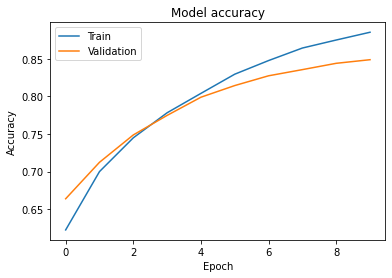

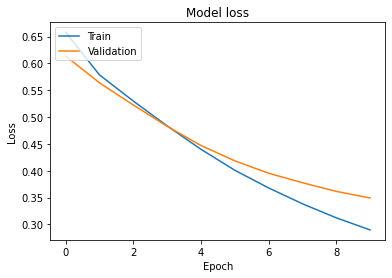

In [32]:
plot_history(pretrained_model_history)